In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
Datapath = r"D:\edu_laptop\Ironhack_AI_&_DataScience\Month_1_2\Week7\Friday\amz_uk_price_prediction_dataset.csv"
df = pd.read_csv(Datapath)
df.head(3)

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers


Part 1: Analyzing Best-Seller Trends Across Product Categories
1. Crosstab Analysis

In [3]:
import pandas as pd

crosstab = pd.crosstab(df["category"], df["isBestSeller"])
crosstab


isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3
...,...,...
Wind Instruments,243,7
Window Treatments,234,5
Women,17559,213


In [4]:
# Proportion of Best-Sellers per Category
best_seller_ratio = (
    crosstab.div(crosstab.sum(axis=1), axis=0)
             .sort_values(by=True, ascending=False)
)

best_seller_ratio


isBestSeller,False,True
category,,
Grocery,0.941865,0.058135
Smart Home Security & Lighting,0.942308,0.057692
Health & Personal Care,0.942314,0.057686
Mobile Phone Accessories,0.957529,0.042471
Power & Hand Tools,0.964661,0.035339
...,...,...
"CD, Disc & Tape Players",1.000000,0.000000
General Music-Making Accessories,1.000000,0.000000
Snowboard Boots,1.000000,0.000000


2. Statistical Tests
Chi-Square Test

In [ ]:
from scipy.stats import chi2_contingency
chi2, p_value, dof, expected = chi2_contingency(crosstab)
chi2, p_value


(36540.20270061387, 0.0)

In [6]:
# Cramér’s V
n = crosstab.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(crosstab.shape) - 1)))
cramers_v


0.1222829439760564

Interpretation

p-value < 0.05 → Best-seller status is not independent of category

Cramér’s V

~0.1 → weak association

~0.3 → moderate

0.5 → strong

3. Visualization – Stacked Bar Chart

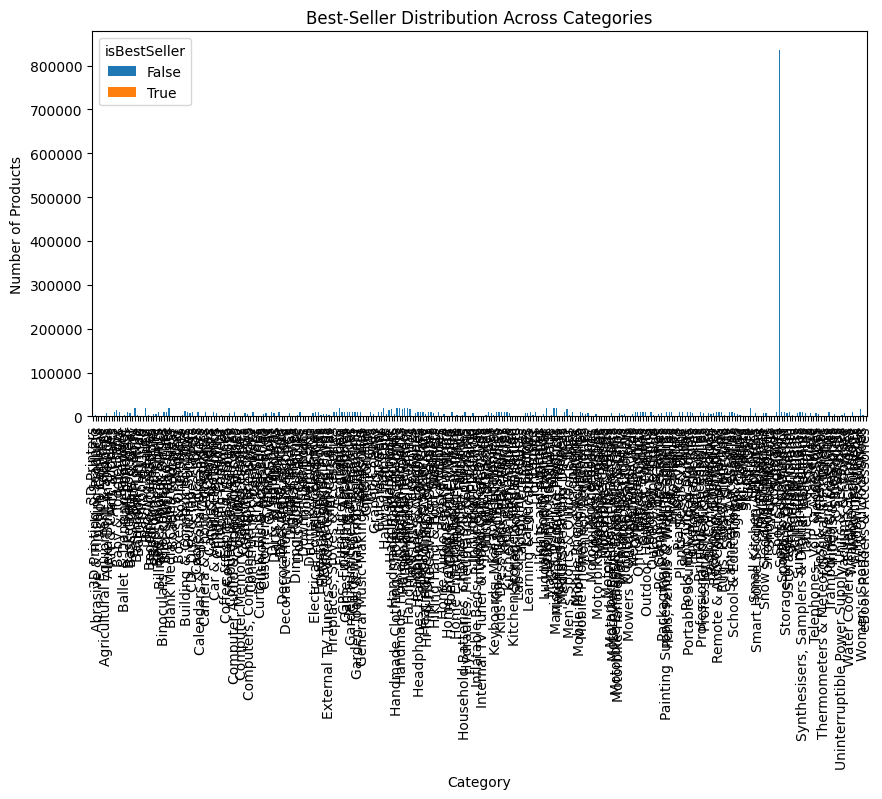

In [7]:
import matplotlib.pyplot as plt
crosstab.plot(
    kind="bar",
    stacked=True,
    figsize=(10,5)
)

plt.xlabel("Category")
plt.ylabel("Number of Products")
plt.title("Best-Seller Distribution Across Categories")
plt.show()


Part 2: Prices and Ratings Across Categories and Brands

Remove Price Outliers (IQR Method)

In [8]:
Q1 = df["price"].quantile(0.25)
Q3 = df["price"].quantile(0.75)
IQR = Q3 - Q1

df_no_outliers = df[
    (df["price"] >= Q1 - 1.5 * IQR) &
    (df["price"] <= Q3 + 1.5 * IQR)
]


1. Violin Plot – Price vs Category (Top 20)

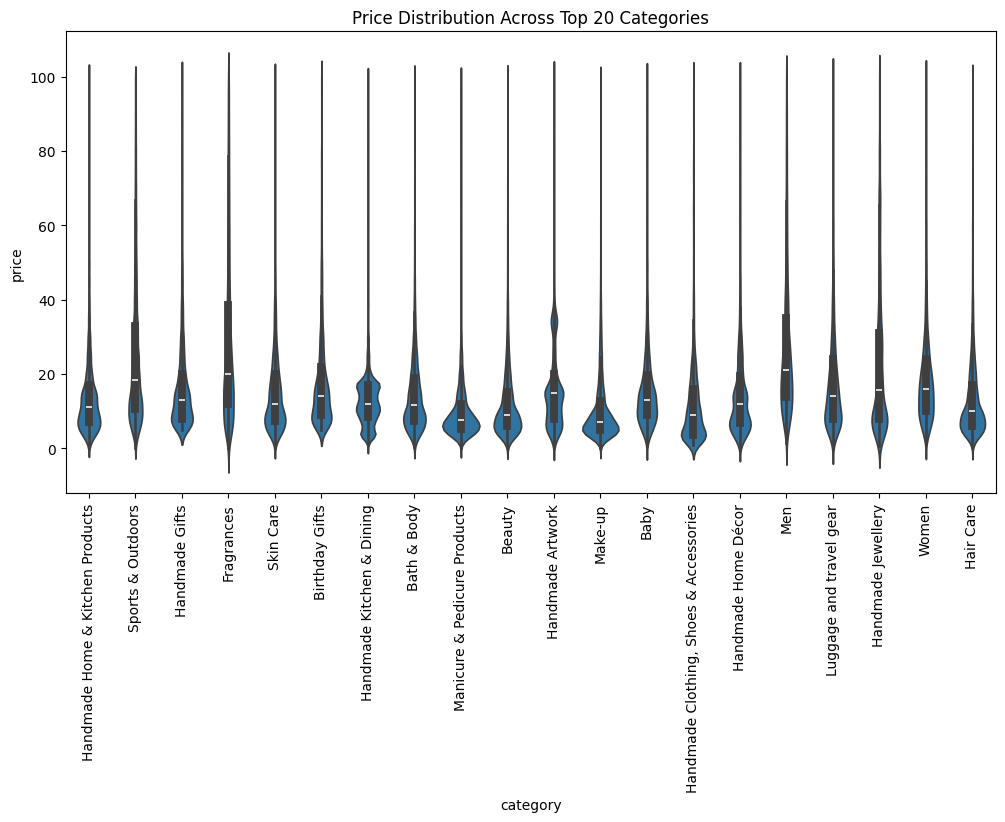

In [ ]:
top20_categories = (
    df_no_outliers["category"]
    .value_counts()
    .head(20)
    .index
)
import seaborn as sns
plt.figure(figsize=(12,6))
sns.violinplot(
    data=df_no_outliers[df_no_outliers["category"].isin(top20_categories)],
    x="category",
    y="price"
)
plt.xticks(rotation=90)
plt.title("Price Distribution Across Top 20 Categories")
plt.show()


Wide violins → diverse pricing strategies

Narrow violins → standardized pricing

Highest median price category often corresponds to electronics, appliances, or specialized equipment.

2. Bar Chart – Average Price (Top 10 Categories)

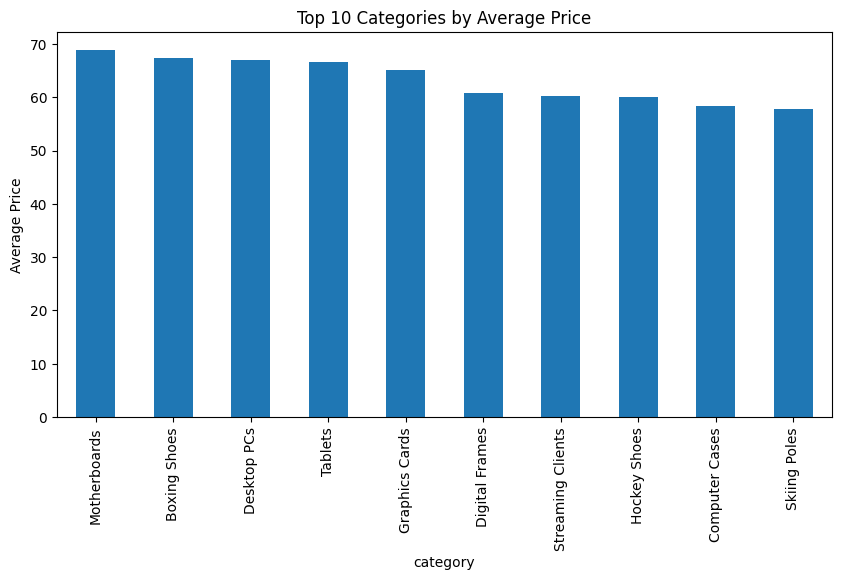

In [10]:
top10_avg_price = (
    df_no_outliers
    .groupby("category")["price"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)
top10_avg_price.plot(kind="bar", figsize=(10,5))
plt.ylabel("Average Price")
plt.title("Top 10 Categories by Average Price")
plt.show()


Categories with high average prices typically:

Have lower volume

Higher margins

Fewer competitors

3. Box Plot – Ratings by Category (Top 10)

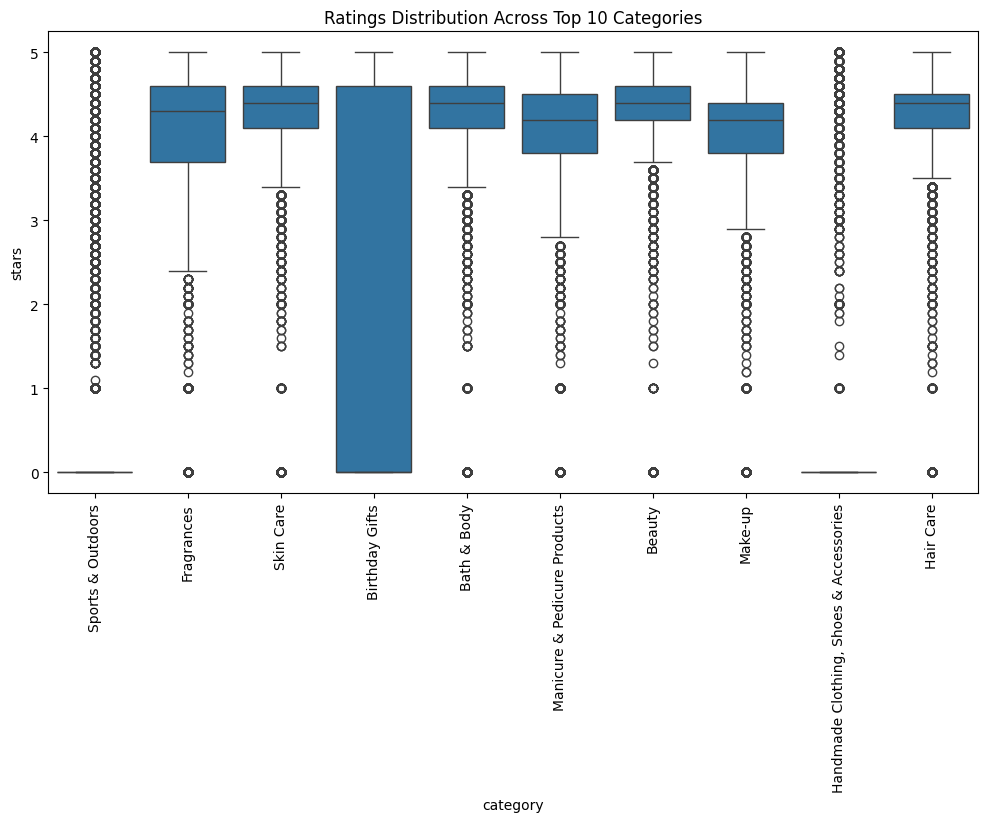

In [11]:
top10_categories_rating = (
    df["category"].value_counts().head(10).index
)
plt.figure(figsize=(12,6))
sns.boxplot(
    data=df[df["category"].isin(top10_categories_rating)],
    x="category",
    y="stars"
)
plt.xticks(rotation=90)
plt.title("Ratings Distribution Across Top 10 Categories")
plt.show()


High median rating + low spread → consistent quality

Low median + wide spread → inconsistent customer experience

Part 3: Interplay Between Prices and Ratings
1. Correlation Coefficient

In [12]:
correlation = df_no_outliers["price"].corr(df_no_outliers["stars"])
correlation


-0.07767299878181444

Correlation near 0 → price does not predict rating

Slight positive correlation is common but not strong

Expensive products are not automatically better rated

2. Visualizations
Scatter Plot

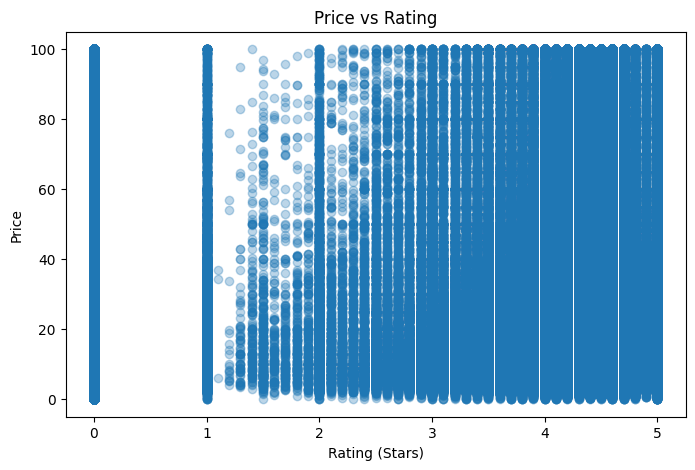

In [13]:
plt.figure(figsize=(8,5))
plt.scatter(df_no_outliers["stars"], df_no_outliers["price"], alpha=0.3)
plt.xlabel("Rating (Stars)")
plt.ylabel("Price")
plt.title("Price vs Rating")
plt.show()


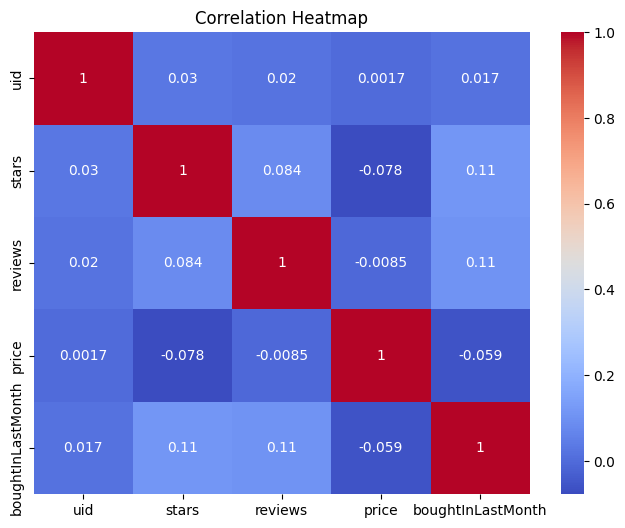

In [14]:
# Correlation Heatmap
numeric_cols = df_no_outliers.select_dtypes(include="number")

plt.figure(figsize=(8,6))
sns.heatmap(numeric_cols.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


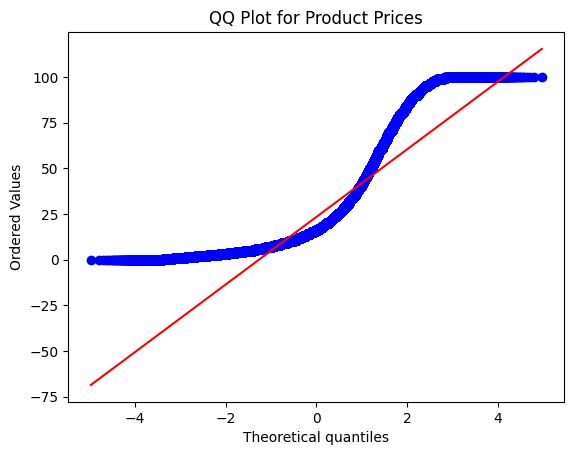

In [15]:
# QQ Plot – Price Normality
import scipy.stats as stats

stats.probplot(df_no_outliers["price"], plot=plt)
plt.title("QQ Plot for Product Prices")
plt.show()
